# Cats and Dogs: Aumentando os dados sinteticamente

## Referência DataLoader: notebook do Gustavo Fonseca

https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

https://krshrimali.github.io/Applying-Transfer-Learning-Dogs-Cats/

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

# from IPython import display

import os, glob
from PIL import Image

import numpy as np

import torch
from torch import nn
import torch.nn.functional as F
import torchvision

device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
print('GPU available:', device)

GPU available: cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

data_prefix = '/content/drive/Shared drives/Drive compartilhado EA999/data_augmentation'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Dataset

O conjunto de dados que vamos usar nesta atividade foi obtido de uma competição do Kaggle, [https://www.kaggle.com/c/dogs-vs-cats/data](https://www.kaggle.com/c/dogs-vs-cats/data). Neste exemplo, utilizaremos as primeiras 1000 imagens de gatos e cachorros como conjunto de treinamento, totalizando 2000 imagens. Para validação usamos as 400 imagens seguintes de cachorros e gatos. O nosso dataset está organizado da seguinte forma:

    /data/catsdogs_fewsamples/
        train/
            dogs/
                dog.0.jpg
                dog.1.jpg
                ...
                dog.999.jpg
            cats/
                cat.0.jpg
                cat.1.jpg
                ...
                cat.999.jpg
        validation/
            dogs/
                dog.1000.jpg
                dog.1001.jpg
                ...
                dog.1399.jpg
            cats/
                cat.1000.jpg
                cat.1001.jpg
                ...
                cat.1399.jpg
            

O PyTorch oferece diversas ferramentas para carregar e pré-processar os dados de maneira bem simples.

Neste caso, vamos usar a classe `ImageFolder` para carregar as imagens de gatos e cachorros do nosso conjunto de dados:

In [ ]:
from torchvision.datasets import ImageFolder
from torchvision import transforms

rootdir = data_prefix + '/data/catsdogs_fewsamples'

dataset_train = ImageFolder(rootdir + '/train/', transform=transforms.ToTensor())
dataset_valid = ImageFolder(rootdir + '/validation/', transform=transforms.ToTensor())

print(dataset_train)
print()
print(dataset_valid)
print()

Dataset ImageFolder
    Number of datapoints: 2000
    Root location: /content/drive/Shared drives/Drive compartilhado EA999/data_augmentation/data/catsdogs_fewsamples/train/
    StandardTransform
Transform: ToTensor()

Dataset ImageFolder
    Number of datapoints: 800
    Root location: /content/drive/Shared drives/Drive compartilhado EA999/data_augmentation/data/catsdogs_fewsamples/validation/
    StandardTransform
Transform: ToTensor()



Podemos verificar algumas amostras para testar o carregamento dos dados:

1
torch.Size([3, 397, 500])


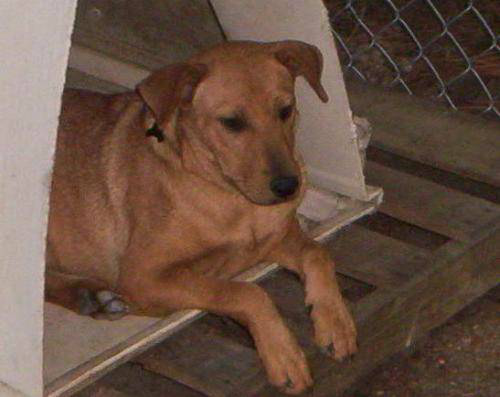

In [ ]:
toPIL = transforms.ToPILImage()
toTensor = transforms.ToTensor()
image, label = dataset_train[1003]
print(label)
print(image.shape)
toPIL(image)

In [ ]:
rootdir = data_prefix + '/data/catsdogs_fewsamples'
path_train = rootdir + '/train/'
path_valid = rootdir + '/validation/'

In [ ]:
from torch.utils.data import Dataset
import glob
from PIL import Image

class CatsDogsDataset(Dataset):
    def __init__(self, path_to_dataset,transform=transforms.ToTensor()):

        super(CatsDogsDataset, self).__init__()
        self.path       = path_to_dataset
        self.list_files = glob.glob(self.path + "**/*.jpg", recursive=False)
        self.files_len  = len(self.list_files)
        self.transform  = transform
        self.to_image   = transforms.ToPILImage()
        
    def __len__(self):
        return self.files_len
    def open_image(self,index):
        if index >= self.files_len:
          print("INDEX OUT OF RANGE")
          return None
        img  = self.list_files[index]
        data = Image.open(img)
        return img,data
    def __getitem__(self, index):
        img,data = self.open_image(index)
        target = 1*("dogs"==(img.split(self.path)[1].split('/')[0]))
        data= self.transform(data)

        return (data, target)

    def print_image(self,index):
        img,data = self.open_image(index)
        data= self.transform(data)
        display(self.to_image(data))

In [ ]:
dataset_train=CatsDogsDataset(path_train)
dataset_valid=CatsDogsDataset(path_valid)

2000
torch.Size([3, 374, 500]) 0


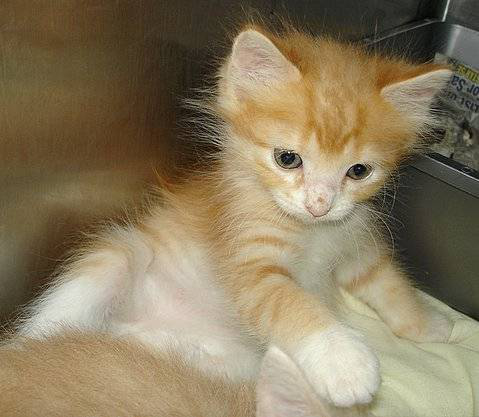

In [ ]:
print(len(dataset_train))
img,target=dataset_valid[200]
print(img.shape, target)
dataset_train.print_image(200)

800
torch.Size([3, 374, 500]) 0


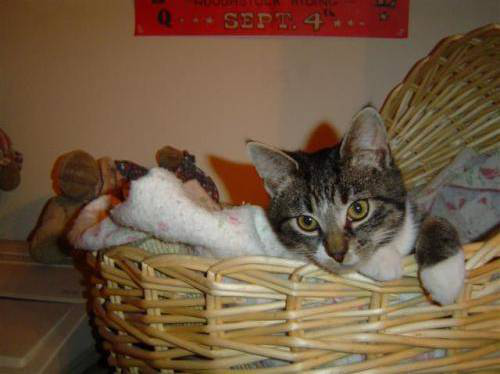

In [ ]:
print(len(dataset_valid))
img,target=dataset_valid[200]
print(img.shape, target)
dataset_valid.print_image(200)

In [ ]:
for i, (data, label) in enumerate(dataset_train):
  print(data.shape)
  if i==5:
    break

torch.Size([3, 374, 500])
torch.Size([3, 499, 403])
torch.Size([3, 200, 296])
torch.Size([3, 280, 300])
torch.Size([3, 499, 489])
torch.Size([3, 174, 215])


<class 'torch.Tensor'>
torch.Size([3, 500, 315]) torch.Size([3, 224, 224])


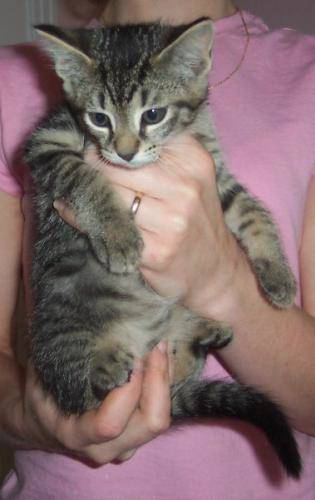

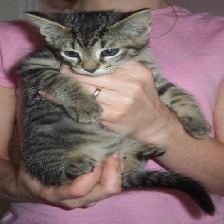

In [ ]:
import torch.nn.functional as F

class Resize():
  def __init__(self, out_size):
    self.out_size=out_size
  def __call__(self, img):
    img=img.unsqueeze(dim=0)
    n_img=F.interpolate(img, size=(self.out_size))
    return n_img.squeeze()

resize_fig=Resize((224,224))
to_image   = transforms.ToPILImage()
img,label=dataset_train[300]
print(type(img))

new_img=resize_fig(img)

print(img.shape,new_img.shape)

display(to_image(img))
display(to_image(new_img))

In [ ]:
transform=transforms.Compose([
                              
      transforms.ToTensor() ,
      Resize((224,224))                            
]
)

In [ ]:
dataset_train=CatsDogsDataset(path_train, transform=transform)
dataset_valid=CatsDogsDataset(path_valid, transform=transform)

2000
torch.Size([3, 224, 224]) 0


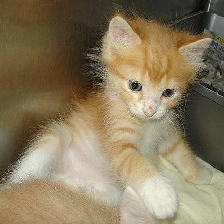

In [ ]:
print(len(dataset_train))
img,target=dataset_valid[200]
print(img.shape, target)
dataset_train.print_image(200)

800
torch.Size([3, 224, 224]) 0


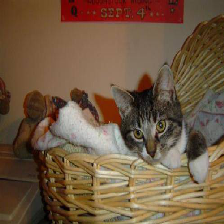

In [ ]:
print(len(dataset_valid))
img,target=dataset_valid[200]
print(img.shape, target)
dataset_valid.print_image(200)

In [ ]:
for i, (data, label) in enumerate(dataset_train):
  print(data.shape)
  if i==5:
    break

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


## DataLoader
Podemos agora definir um DataLoader para facilitar a carregamento dos dados durante o treinamento:

In [ ]:
N_SAMPLES = len(dataset_train)
N_BATCHES= 100
BATCH_SIZE = N_SAMPLES//N_BATCHES

In [ ]:
loader = torch.utils.data.DataLoader(
    dataset=dataset_train, 
    batch_size=BATCH_SIZE, 
    shuffle=True)

print(type(loader))

(x,y) = iter(loader).next()
print(x.shape, y.shape)

<class 'torch.utils.data.dataloader.DataLoader'>
torch.Size([20, 3, 224, 224]) torch.Size([20])


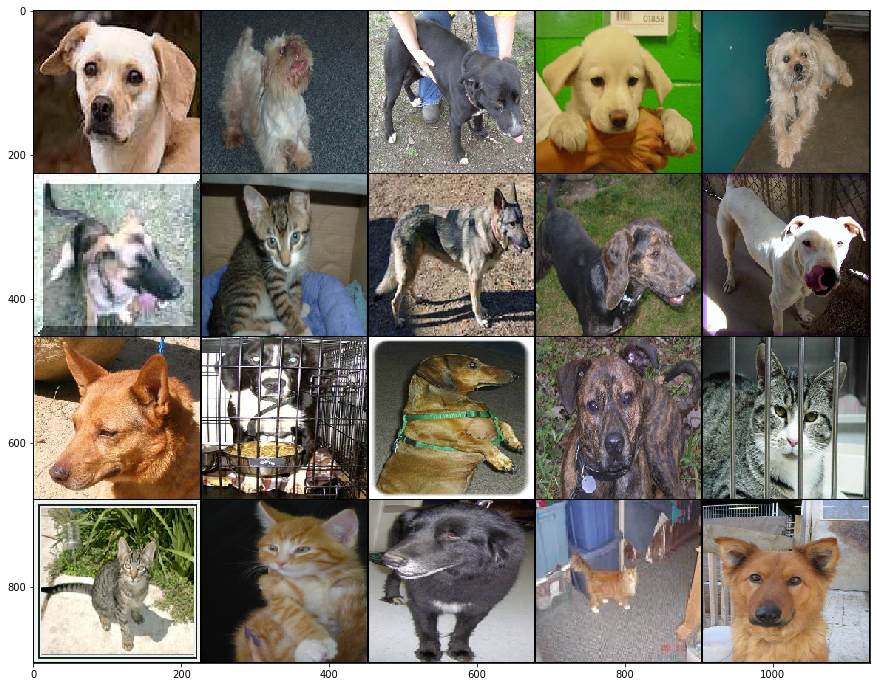

In [ ]:
grid_img = torchvision.utils.make_grid(x, nrow=5)

plt.figure(figsize = (15,12))
plt.imshow(grid_img.permute(1, 2, 0), aspect='auto');

In [ ]:
transform = transforms.Compose([transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                ])

In [ ]:
rootdir = data_prefix + '/data/catsdogs_fewsamples'

# dataset_train_aug = ImageFolder(rootdir + '/train/', transform=transform_aug)
dataset_train = ImageFolder(rootdir + '/train/', transform=transform)
dataset_valid = ImageFolder(rootdir + '/validation/', transform=transform)

# print(dataset_train_aug)
print()
print(dataset_train)
print()
print(dataset_valid)
print()


Dataset ImageFolder
    Number of datapoints: 2000
    Root location: /content/drive/Shared drives/Drive compartilhado EA999/data_augmentation/data/catsdogs_fewsamples/train/
    StandardTransform
Transform: Compose(
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

Dataset ImageFolder
    Number of datapoints: 800
    Root location: /content/drive/Shared drives/Drive compartilhado EA999/data_augmentation/data/catsdogs_fewsamples/validation/
    StandardTransform
Transform: Compose(
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )



In [ ]:
loader = torch.utils.data.DataLoader(
    dataset=dataset_train, 
    batch_size=BATCH_SIZE, 
    shuffle=True)

loader_valid = torch.utils.data.DataLoader(
    dataset=dataset_valid, 
    batch_size=BATCH_SIZE, 
    shuffle=True)

## Modelo c/ Transfer Learning



In [ ]:
LR = 0.001
EPOCH = 10
# n_epochs_stop = 25   #paciencia

model = torchvision.models.resnet18(pretrained = True)

for param in model.parameters():
    param.requires_grad = False

model.fc = torch.nn.Linear(512, 2)

for param in model.fc.parameters():
	param.requires_grad = True

optimizer = torch.optim.Adam(model.fc.parameters())

loss_function = torch.nn.CrossEntropyLoss()


# model = model.to(device)
# trainer = Training(LR,EPOCH,model,n_epochs_stop)


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [ ]:
loss_his = []

best_loss = 10

for epoch in range(EPOCH):
  for i , (images,labels) in enumerate(loader):
    
    optimizer.zero_grad()
    outputs = model(images)
    loss = loss_function(outputs, labels)
    loss.backward()
    optimizer.step()

    loss_his.append(loss)

    if loss < best_loss:
      best_loss = loss
      torch.save(model.state_dict(), 'saved_model')
      print('Saved new best model...')

    print('Epoch [%d], Loss: %.4f' % (epoch+1, loss.item()) )

Saved new best model...
Epoch [1], Loss: 0.7053
Saved new best model...
Epoch [1], Loss: 0.6744
Epoch [1], Loss: 0.6953
Saved new best model...
Epoch [1], Loss: 0.6395
Saved new best model...
Epoch [1], Loss: 0.4786
Epoch [1], Loss: 0.6358
Epoch [1], Loss: 0.6467
Epoch [1], Loss: 0.4924
Epoch [1], Loss: 0.5253
Epoch [1], Loss: 0.5277
Saved new best model...
Epoch [1], Loss: 0.4434
Saved new best model...
Epoch [1], Loss: 0.4389
Epoch [1], Loss: 0.4712
Epoch [1], Loss: 0.7631
Epoch [1], Loss: 0.5720
Epoch [1], Loss: 0.5148
Saved new best model...
Epoch [1], Loss: 0.4201
Saved new best model...
Epoch [1], Loss: 0.3728
Epoch [1], Loss: 0.5425
Epoch [1], Loss: 0.4206
Epoch [1], Loss: 0.3831
Epoch [1], Loss: 0.5436
Epoch [1], Loss: 0.7834
Saved new best model...
Epoch [1], Loss: 0.3374
Saved new best model...
Epoch [1], Loss: 0.3116
Epoch [1], Loss: 0.3283
Epoch [1], Loss: 0.3521
Epoch [1], Loss: 0.3550
Saved new best model...
Epoch [1], Loss: 0.2370
Epoch [1], Loss: 0.2820
Epoch [1], Loss:

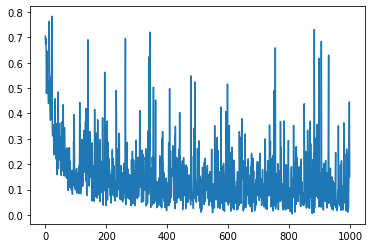

In [ ]:
import matplotlib.pyplot as plt

plt.plot(loss_his)

In [ ]:
model.load_state_dict(torch.load('saved_model'))

<All keys matched successfully>

## Acurácia do Modelo

In [ ]:
n_acertos = 0
total = 0

for images,labels in loader_valid:
  
  output = model(images)
  _, predicted = torch.max(output,1)
  n_acertos += (predicted == labels).sum()
  total += labels.size(0)

print('Acurácia do modelo: %.1f %%' %((100*n_acertos)/(total+1)))

print('Perda treino %.5f: ' % loss_his[-1])

#print('Perda validação %.2f: ' % loss_val_his[-1])

Acurácia do modelo: 95.0 %
Perda treino 0.15035: 


Acurácia do modelo: 95.0 %


In [ ]:
print('Menor perda: %.5f ' % best_loss)

Menor perda: 0.00403 


Menor perda: 0.00403
